In [1]:
import sys
import os

# Get the absolute path of the parent directory.
parent_dir = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))

# Add the parent directory to the system path to be able to import modules from 'lib.'
sys.path.append(parent_dir)

In [2]:
import datasets

from datetime import datetime
import ipywidgets as widgets
from IPython.display import HTML, Markdown as md
import itertools

from lib.memory import DSDM
from lib.utils import cleanup, configs, inference, learning, preprocess, utils 

import math
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
from nltk.corpus import stopwords
import numpy as np
import random

import pandas as pd
import pathlib
import pickle

import string
import seaborn as sns

from transformers import AutoTokenizer, AutoModel

import torch
import torchhd as thd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F 

from tqdm import tqdm

### Package options ###
torch.set_printoptions(threshold=10_000)

[nltk_data] Downloading package punkt to
[nltk_data]     /nfs/home/dfichiu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /nfs/home/dfichiu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
### Utils ###
def plot_heatmap(x: np.array, labels: np.array) -> None:
    plt.figure(figsize=(15, 15))
    sns.heatmap(
        x,
        linewidth=0.5,
        xticklabels=labels,
        yticklabels=labels,
        annot=True,
        fmt='.2f',
    )
    plt.title(f'Self-attention matrix: layer {layer}, head {head}', fontsize=15)
    
    plt.show()
    return

def average_out_and_remove_rows(t: torch.tensor, averages_idx, remove_idx):
    for average_idx in averages_idx:  # The nested lists can have different dimensions.
        # Replace the attention scores of the first token with the average of the token attention scores.
        t[min(average_idx)] = torch.mean(t[average_idx], dim=0, keepdim=True)
    return t[~remove_idx]


def preprocess_attention_scores(attention_scores, averages_idx, remove_idx):
    attention_scores = average_out_and_remove_rows(attention_scores, averages_idx, remove_idx)
    attention_scores = attention_scores.transpose(0, 1)
    attention_scores = average_out_and_remove_rows(attention_scores, averages_idx, remove_idx)
    return attention_scores.transpose(0, 1)
        
    

def backward_pass(G, current_node, left_edge, right_edge, sequence, mean):
    in_nodes = np.array([edge[0] for edge in list(G.in_edges(current_node))])
    in_nodes = in_nodes[(in_nodes > left_edge) & (in_nodes < current_node)]
    for node in in_nodes:
        sequence[node] = 1
        sequences.append(sequence)
        mean += G[node][current_node]['weight']
        means.append(round(mean / (sum(sequence) - 1), 2))
        backward_pass(G, node, left_edge, node, sequence.copy(), mean)
        forward_pass(G, node, left_edge, current_node, sequence.copy(), mean)
        
    return
    
    
def forward_pass(G, current_node, left_edge, right_edge, sequence, mean):
    out_nodes = np.array([edge[1] for edge in list(G.out_edges(current_node))])
    out_nodes = out_nodes[(out_nodes > current_node) & (out_nodes < right_edge)]
    for node in out_nodes:
        sequence[node] = 1
        mean += G[current_node][node]['weight']
        sequences.append(sequence)
        means.append(round(mean / (sum(sequence) - 1), 2))
        backward_pass(G, node, current_node, node, sequence.copy(), mean)
        forward_pass(G, node, node, right_edge, sequence.copy(), mean)
            
    return
    

def construct_sequences(G: nx.DiGraph, n_tokens):
    for node in G.nodes():
        sequence = np.zeros(n_tokens)
        mean = 0
        sequence[node] = 1
        #sequences.append(sequence) # Do not allow for 1-token sequences.
        forward_pass(G, node, node, n_tokens, sequence.copy(), mean)

In [4]:
def save_memory(cleanup, memory):
    now = str(datetime.now()).replace(':', "-").replace('.', '-')
    
    if not os.path.exists('memories/method2'):
        os.makedirs('memories/method2')
    if not os.path.exists('cleanups/method2'):
        os.makedirs('cleanups/method2')
        
    with open(f'memories/method2/memory_{now}.pkl', 'wb') as outp:
        pickle.dump(memory, outp, pickle.HIGHEST_PROTOCOL)
    with open(f'cleanups/method2/cleanup_{now}.pkl', 'wb') as outp:
        pickle.dump(cleanup, outp, pickle.HIGHEST_PROTOCOL)

In [5]:
# Load Wikipedia dataset.
# TODO: Split between server and local.
#wiki_dataset = datasets.load_dataset("wikipedia", "20220301.en")['train']
wiki_dataset = datasets.load_dataset(
    "wikipedia",
    "20220301.en",
    cache_dir="/nfs/data/projects/daniela")['train']

Found cached dataset wikipedia (/nfs/data/projects/daniela/wikipedia/20220301.en/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559)


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seed.
utils.fix_seed(41)

Using seed: 41

In [7]:
# These parameters shouldn't change.
address_size = 1000
ema_time_period = 100000
learning_rate_update = 0

normalize = False 

as_threshold = 0.5


temperature = 0.05

prune_mode = "fixed-size"
max_size_address_space = 10

safeguard_bins=True
bin_score_threshold_type = 'static'
bin_score_threshold = 1e-8

safeguard_chunks=True
chunk_score_threshold = 0.8

In [8]:
cleanup = cleanup.Cleanup(address_size)

In [9]:
model_name = "bert-base-uncased"  # Has 12 layers
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

MAXIMUM_SEQUENCE_LENGTH = 512

In [10]:
memory = DSDM.DSDM(
    address_size=address_size,
    ema_time_period=ema_time_period,
    learning_rate_update=learning_rate_update,
    temperature=temperature,
    normalize=normalize,
    prune_mode=prune_mode,
    max_size_address_space=max_size_address_space,
    safeguard_bins=safeguard_bins,
    bin_score_threshold_type=bin_score_threshold_type,
    bin_score_threshold=bin_score_threshold,
    safeguard_chunks=safeguard_chunks,
    chunk_score_threshold=chunk_score_threshold,
)

In [11]:
# Initialize memory.
# memory = DSDM.DSDM(
#     address_size=address_size,
#     ema_time_period=ema_time_period,
#     learning_rate_update=learning_rate_update,
#     temperature=temperature,
#     normalize=normalize,
#     prune_mode=prune_mode,
#     max_size_address_space=max_size_address_space,
#     bin_score_threshold=bin_score_threshold,
#     chunk_score_threshold=chunk_score_threshold,
# ) 

In [12]:
# Construct train set (texts) and inference set (sentences; in and out of train set text).
train_size = 100
test_size = 100

# Text indeces.
train_idx = np.random.randint(0, len(wiki_dataset), size=train_size)
#train_idx = np.append(np.append(np.append(train_idx[0], train_idx[0]), train_idx[0]), train_idx[0]) 

# Caclulate chosen text statistics.
# TODO

# Text indeces from which we extract sentences.
intest_idx = np.random.choice(train_idx, test_size)
outtest_idx = np.random.choice(np.setdiff1d(np.arange(len(wiki_dataset)), train_idx), test_size)

In [13]:
inference_sentences_in = []
inference_sentences_out = []

for idx_in, idx_out in zip(intest_idx, outtest_idx):
    # Get sentences.
    sentences_in = utils.preprocess.split_text_into_sentences(wiki_dataset[int(idx_in)]['text'])
    sentences_out = utils.preprocess.split_text_into_sentences(wiki_dataset[int(idx_out)]['text'])
    
    # Get sentence index.
    sentence_idx_in = np.random.randint(0, len(sentences_in), size=1).item()
    sentence_idx_out = np.random.randint(0, len(sentences_out), size=1).item()

    # Append sentence to list.
    inference_sentences_in.append(sentences_in[sentence_idx_in])
    inference_sentences_out.append(sentences_out[sentence_idx_out])

In [14]:
dups_found = 0

def remove_duplicates(memory):
    global dups_found
    global_keep_mask = torch.tensor([True] * len(memory.addresses)).to(device)
    
    for idx, address in enumerate(memory.addresses):
        if global_keep_mask[idx].item():
            cos = torch.nn.CosineSimilarity()
            keep_mask = cos(memory.addresses, address) < 0.95
            # Keep current address
            keep_mask[idx] = True
            global_keep_mask &= keep_mask

    if global_keep_mask.sum().item() > 0:
        dups_found += 1
        # Remove similar addresses
        memory.addresses = memory.addresses[global_keep_mask]
        # Remove bins
        memory.bins = memory.bins[global_keep_mask]
        # Remove chunk scores
        memory.chunk_scores = memory.chunk_scores[global_keep_mask]

In [15]:
# Training
for pos, i in enumerate(tqdm(train_idx)):
    memory.add_wiki_article(int(i))
    text = wiki_dataset[int(i)]['text']
    
    # Preprocess data. 
    sentences = preprocess.split_text_into_sentences(text)
    
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors="pt")
        if inputs['input_ids'].shape[1] > MAXIMUM_SEQUENCE_LENGTH:
            break
        
        outputs = model(**inputs, output_attentions=True)
        attention_matrix = outputs.attentions
        
        encoding = tokenizer.encode(sentence)
        labels = tokenizer.convert_ids_to_tokens(encoding)

        i = 0
        averages_idx = []
        while i < len(labels) - 1:
            j = i + 1
            average_idx = []
            while labels[j].startswith('#'):
                average_idx.append(j)
                labels[i] += labels[j].replace('#', '')
                j += 1
            if average_idx != []:
                average_idx.append(i)
                averages_idx.append(average_idx)
            i = j
        
        hashtag_idx = np.array([label.startswith("#") for label in labels])
        stopwords_idx = np.array([label in stopwords.words('english') for label in labels])
        punctuation_idx = np.array([label in string.punctuation for label in labels])
        remove_idx = hashtag_idx | punctuation_idx #| stopwords_idx
        labels = np.array(labels)[~remove_idx]
        labels = labels[1:(len(labels) - 1)]

        layer = 0
        for head in range(12):
            head_scores_raw_tensor = attention_matrix[layer][0][head].detach().clone()
        
            head_scores_raw_tensor = preprocess_attention_scores(head_scores_raw_tensor, averages_idx, remove_idx)
            
            head_scores_raw = head_scores_raw_tensor.cpu().detach().numpy()
            
            head_scores = head_scores_raw[1:(len(head_scores_raw) - 1), 1:(len(head_scores_raw) - 1)].copy()
    
            head_scores[head_scores < as_threshold] = 0
            
            G = nx.from_numpy_array(head_scores, create_using=nx.DiGraph())
        
            sequences = []
            means = []
            n_tokens = len(labels)
            construct_sequences(G, n_tokens)
                
            df = pd.DataFrame(data=[sequences, means]).T.rename(columns={0: 'seq',  1: 'score'})
            
            if len(df) > 0:
                df['len'] = df['seq'].map(sum)
                df['score'] = df['score'].astype('float64')
                df = df.sort_values(by=['score', 'len'], ascending=[False, False]).reset_index(drop=True)
                top3_df = df.head(3)
            
                for i in range(len(top3_df)):
                    memory.save(
                        inference.generate_query(
                            address_size,
                            cleanup,
                            labels[top3_df['seq'][i].astype(bool)]
                        ),
                        top3_df['score'][i]
                    )
        memory.prune()
#     if (pos + 1) % 50 == 0:
#         remove_duplicates(memory)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:58<00:00,  1.79s/it]


In [16]:
#save_memory(cleanup, memory)

In [17]:
retrieve_mode = "top_k"

# Get table with token similarities for each "out-of-train" sentence.
retrieved_contents = inference.infer(
    memory.address_size,
    cleanup,
    memory,
    inference_sentences_in,
    retrieve_mode=retrieve_mode,
    k=7, #TODO: What if index is out of range?
)

if retrieve_mode == "top_k":
    sims_df = pd.DataFrame(columns=['sentence', 'token', 'similarity']) 
    
    for s, addresses in zip(inference_sentences_in, retrieved_contents):
        display(s)
        out_tables = []
        for a in addresses:
            address_sims_df = inference.get_similarities_to_atomic_set(
                a, cleanup)
            out = widgets.Output()
            with out:
                display(address_sims_df)
            out_tables.append(out)
        display(widgets.HBox(out_tables))
elif retrieve_mode == "pooling":  
    sims_df = pd.DataFrame(columns=['sentence', 'token', 'similarity']) 
      
    for s, c in zip(inference_sentences_in, retrieved_contents):
        sentence_sims_df = inference.get_similarities_to_atomic_set(
            c, cleanup)
        sentence_sims_df['sentence'] = [s] * len(sentence_sims_df)
        sims_df = pd.concat([sims_df, sentence_sims_df])

    sims_df = sims_df.sort_values(['sentence', 'similarity'], ascending=False) \
                     .set_index(['sentence', 'token'])
    
    display(sims_df)
else:  # unrecognized
    pass

"Odom, an attorney-turned-musician was featured in the John Berendt non-fiction novel Midnight in the Garden of Good and Evil, although he died three years before the book's 1994 release."

'Gal Koren (born January 16, 1992) is a Slovenian professional ice hockey player who is currently under contract to HK Olimpija of the Alps Hockey League (AlpsHL).'

'Hausser\'s books, along with those by other key HIAG members and former Waffen-SS generals Felix Steiner and Kurt Meyer, have been characterised by the historian Charles Sydnor as the "most important works of [Waffen-SS] apologist literature."'

"1492–1538: Charles II, son of Adolf\n\nHouse of La Marck\n\n 1538–1543: William II, distant relative and successor of the House of Egmond\n\nHouse of Habsburg\n\n 1543–1555: Charles V, son of Philip I\n 1555–1598: Philip II, son of Charles V\n\nGuelders in popular culture\n\nWilliam Thatcher, the lead character in the 2001 film A Knight's Tale played by Heath Ledger claimed to be Sir Ulrich von Liechtenstein from Gelderland so as to appear to be of noble birth and thus qualify to participate in jousting."

"Later years and death\n\nIn 1988, Grimshaw designed the cover for Iggy Pop's album Instinct."

'Cooper made his debut for Staffordshire in the 2001 MCCA Knockout Trophy against the Derbyshire Cricket Board.'

"Baylor University scandal  may refer to:\n\nBaylor University basketball scandal, a scandal which broke out after the murder of men's basketball player Patrick Dennehy at Baylor University\nBaylor University sexual assault scandal, a sexual assault scandal centering around football players at Baylor University"

'Jake Goodman may refer to:\n Jake Goodman (baseball) (1853–1890), Major League Baseball player\n Jake Goodman (footballer) (born 1993), English footballer'

'She donated the land and created its financial endowment for the Arboretum in 1981.'

"Koren competed at the 2013 IIHF World Championship as a member of the Slovenia men's national ice hockey team."

'It now handles only youth football.'

'History \n\nThe Baltic Institute was established in 1925 in Toruń, beginning real activities in 1927, with the main goal of documenting the Polish heritage in Pomerania after 100 years of German occupation and Germanization practices.'

'non-red) colour.'

'We should not punish the innocent."'

'Kevin Lynch may refer to:\nKevin Lynch (basketball) (born 1968), Minnesota basketball player\nKevin Lynch (beach volleyball) (born 1984), American beach volleyball player\nKevin Lynch (computing), VP at Apple, former CTO of Adobe Systems\nKevin Lynch (hunger striker) (1956–1981), Irish republican\nKevin Lynch (ice hockey) (born 1991), American ice hockey player\nKevin Lynch (judge) (1927–2013), Irish Supreme Court judge\nKevin A. Lynch (1918–1984), American urban planner\n Kevin Lynch Award, named in his honor\nKevin G. Lynch (born 1951), Canadian civil servant\nKevin Lynch, a fictional Criminal Minds character'

"He worked as a librarian in the village's library."

'A large, dome-like structure occupies the interior of the crater, suggesting the crater has undergone significant viscous relaxation.'

"Baylor University scandal  may refer to:\n\nBaylor University basketball scandal, a scandal which broke out after the murder of men's basketball player Patrick Dennehy at Baylor University\nBaylor University sexual assault scandal, a sexual assault scandal centering around football players at Baylor University"

'The plant grows together with sandstone fynbos in mountainous shale at altitudes of 330-860\xa0m.\n\nReferences\n\nExternal links \n Threatened Species Programme | SANBI Red List of South African Plants\n Sorocephalus imbricatus (Tile-leaf clusterhead)\n https://www.proteaatlas.org.za/Protea_Atlas_Sorocephalus.pdf\n Tileleaf Powderpuff\n\nProteaceae\nFlora of South Africa'

'In 2014, she began in the lead role of Tara Crossley in the Disney Channel drama series.'

'In 1789 he moved to London.'

'Club career\nMusolitin is a product of youth team system of FC Chornomorets.'

'She later married Herman, Duke of Carinthia.'

'In early 2016, contacts were made between the SBMM and the Maritime Heritage Vlissingen Foundation (SMEV) to see whether the ship could serve as a museum ship in Vlissingen after the asbestos removal.'

'It premiered on DVD and the Showtime Cable channel in 2006.'

'Gal Koren (born January 16, 1992) is a Slovenian professional ice hockey player who is currently under contract to HK Olimpija of the Alps Hockey League (AlpsHL).'

'NGC 1803 is a barred spiral galaxy located in the constellation of Pictor at an approximate distance of 192.48 million light years.'

'Events from the year 1822 in Denmark.'

'The total area was 90.49\xa0km².'

"Baylor University scandal  may refer to:\n\nBaylor University basketball scandal, a scandal which broke out after the murder of men's basketball player Patrick Dennehy at Baylor University\nBaylor University sexual assault scandal, a sexual assault scandal centering around football players at Baylor University"

'On August 29, 2018, Krieger joined Alice in Chains onstage at the Hollywood Palladium in Los Angeles to close out their sold-out concert with a performance of their hit song "Rooster".'

'NGC 1803 is a barred spiral galaxy located in the constellation of Pictor at an approximate distance of 192.48 million light years.'

"Liu's army directly headed for the headquarters, where Deng Chuna was holding a feast."

'Actress Piya Sengupta is his wife and his son Bonny Sengupta is also an actor.'

'In 1972, Secretariat won the race but was disqualified and set back to second.'

'The about 7 whorls are flat or concave below the sutures, convex and swollen at the periphery and above each suture.'

'The Fars Province is in the south of the Iran and its capital city is Shiraz .'

'Also, there are many varieties.'

'History  \n\nIn 1962 a vehicular bridge over Drava River was built in Osijek.'

'It was published when Camus was 23 years old.'

'See also\nList of stations on Jingbao railway\n\nRailway stations in Shanxi'

'References \n\nPopulated places in Chad'

'non-red) colour.'

'"An adiabatic invariant for single-particle motion in static axisymmetric magnetic fields with large wave-number variations."'

'Life\nLi Ru was from Heyang County (), Zuopingyi (), which is in present-day Heyang County, Shaanxi.'

'KY\xa0357 goes in a north-northeasterly path and meets the eastern terminus of KY\xa0728 at Hammonville.'

'Also, there are many varieties.'

'Cast\n   Rosa Carmina  \n Fernando Fernández  \n Gina Cabrera  \n Alberto González Rubio  \n Luciano de Pazos  \n Salvador Quiroz \n Acela Vidaurri \n Fernando Torres \n Guillermo Bravo Sosa\n\nReferences\n\nBibliography \n María Luisa Amador.'

'They feed on the generative organs of their host plant.'

'References \n\nPopulated places in Andimeshk County'

'Releases \nAs of 2008, Dagored has released 79 titles (some were issued both on LP and CD formats):\n\nReferences \n\nItalian record labels\nRecord labels established in 1998'

'In Romance of the Three Kingdoms\nLi Ru has a greater role as a minor character in the 14th-century historical novel Romance of the Three Kingdoms, which romanticises the events before and during the Three Kingdoms period.'

'It was released on DVD in 2005 by Vanguard Cinema.'

'Elevated concentrations of toxins produced by the staphylococci were also detected in the ham, explaining the extremely short incubation time.'

'About one hour after breakfast, while approaching Copenhagen, 196 passengers and one flight attendant fell ill with nausea, vomiting, diarrhea and abdominal cramps.'

'The year 2016 in Japanese music.'

'Incumbents\n Monarch – Frederick VI\n\nEvents\n28 February – Spare- og Laanekassen i Marstal, a savings bank on the island of Ørø, is founded by a group of local residents.'

'Pierre Auger may refer to:\n\n Pierre Victor Auger (1899–1993), French physicist\n Pierre Auger (biologist) (born 1953), French bio-mathematician\n Pierre-Michel Auger (born 1963), Canadian politician'

'Population\n\nSee also\nCommunes of the Hautes-Pyrénées department\n\nReferences\n\nCommunes of Hautes-Pyrénées'

'Built for Eliza Jewett, it later become the home of Joe Odom.'

'References\n\nsupinella\nMoths of Europe\nMoths described in 1949'

'Cultural and associative activity \n\nHe wrote opinion articles in the Diario Español and Semanario Reus under the pseudonym Suero Vital.'

'Anup Sengupta is a Bengali film Director and Producer.'

"That is not the only reason he is considered one of Stuttgart's most influential Master Builders."

'Disc One:\n "Straight, No Chaser" - 9:46\n "Pannonica" - 7:46\n "Just a Gigolo" (Julius Brammer, Irving Caesar, Leonello Casucci) - 2:30\n "Evidence (Justice)" - 7:55\n "Jackie-ing" - 5:07\n "Bemsha Swing" (Denzil Best, Thelonious Monk) - 4:25\n "Epistrophy [theme]" (Kenny Clarke, Monk) - 1:10\nDisc Two:\n "I\'m Getting Sentimental Over You" (George Bassman, Ned Washington) - 9:28\n "Hackensack" - 11:03\n "Blue Monk" - 13:18\n "Epistrophy" (Clarke, Monk) - 8:25\n\nPersonnel \n Thelonious Monk – piano\n Charlie Rouse - tenor saxophone\n Butch Warren – bass\n Frankie Dunlop – drums\n\nReferences \n\nThelonious Monk live albums\n1963 live albums\nColumbia Records live albums'

"During this process, two of the three commissioners of the currently registered political parties supported the PPR's certification."

'Indraneil Sengupta, his brother is also an actor.'

'Sheri Nashist at the UGC ASC in honour of Dr. Syed Amin.'

'The body whorl is a trifle deflexed at the aperture and is often subangular at the periphery.'

'K-41 is a two-lane highway along its entire route.'

'The plant grows together with sandstone fynbos in mountainous shale at altitudes of 330-860\xa0m.\n\nReferences\n\nExternal links \n Threatened Species Programme | SANBI Red List of South African Plants\n Sorocephalus imbricatus (Tile-leaf clusterhead)\n https://www.proteaatlas.org.za/Protea_Atlas_Sorocephalus.pdf\n Tileleaf Powderpuff\n\nProteaceae\nFlora of South Africa'

'Time Out called it "broadly predictable and increasingly one note, but passable sadistic fun."'

'If the device running the app is equipped with a camera, the app can create a mixed reality experience that will allow you to tap on a surface you are viewing, and the 3D model will drop onto that surface.'

'The village of Washi is 22\xa0km by road northeast of the town of Bhoom, and 25\xa0km by road northwest of Yermala.'

'Lines\nShimo-Yuzawa Station is served by the Ōu Main Line, and is located 214.5\xa0km from the terminus of the line at Fukushima Station.'

'Star Without Light (Spanish: Estrella sin luz) is a 1953 Mexican drama film directed by Ernesto Cortázar and starring Rosa Carmina, Fernando Fernández and Gina Cabrera.'

'References\n\nCadmium compounds\nBromides\nMetal halides\nPhotographic chemicals'

'Programs focus on art history, as well as native plants, animals, conservation and recycling.'

'Coleophora supinella is a moth of the family Coleophoridae.'

'The first single featuring Stella\'s vocals, "We Are the World", managed to break charts in the Czech Republic and Netherlands, but was unable to continue the band\'s large success.'

'References\n\nExternal links\n\n1992 births\nLiving people\nPeople from Domžale\nHDD Olimpija Ljubljana players\nKelowna Rockets players\nKHL Medveščak Zagreb players\nManchester Storm (2015–) players\nSlovenian ice hockey centres'

'Since 1 January 2010, it is part of the town Lützen.'

'It is found along the south-western coast of Florida in the United States, as well as Dominica, Belize and Ecuador.'

'Time Out called it "broadly predictable and increasingly one note, but passable sadistic fun."'

'Rényi showed that the Hartley function in base 2 is the only function mapping natural numbers to real numbers that satisfies\n\n  (additivity)\n  (monotonicity)\n  (normalization)\n\nCondition 1 says that the uncertainty of the Cartesian product of two finite sets A and B is the sum of uncertainties of A and B.'

'UNAM, 1985.'

'Muhammad Javed is the name of:\n\n Muhammad Javed Ikhlas (born 1955), mayor of Rawalpindi, Pakistan\n Muhammad Javed Buttar (born 1948), former justice of Supreme Court of Pakistan\n Makhdoom Muhammad Javed Hashmi (born 1948), Pakistani politician\n Muhammad Javed (cricketer) (born 1964), Pakistani cricketer\n Muhammad Javed (field hockey), Pakistani field-hockey player in 2008 Olympics team squad'

"On November 24, 2020, Harvard Extension School named Ms. Williams (C.S.S., '91) the recipient of its 2020 Dean Michael Shinagel Award for Service to Others, presented by the Harvard Extension Alumni Association."

'Red Robin is an American restaurant chain.'

'This article contains information about the literary events and publications of 1533.'

'They won the Campeonato Amapaense in 1960, 1961, 1962, 1965, 1968, 1972, 1985.'

'Disc One:\n "Straight, No Chaser" - 9:46\n "Pannonica" - 7:46\n "Just a Gigolo" (Julius Brammer, Irving Caesar, Leonello Casucci) - 2:30\n "Evidence (Justice)" - 7:55\n "Jackie-ing" - 5:07\n "Bemsha Swing" (Denzil Best, Thelonious Monk) - 4:25\n "Epistrophy [theme]" (Kenny Clarke, Monk) - 1:10\nDisc Two:\n "I\'m Getting Sentimental Over You" (George Bassman, Ned Washington) - 9:28\n "Hackensack" - 11:03\n "Blue Monk" - 13:18\n "Epistrophy" (Clarke, Monk) - 8:25\n\nPersonnel \n Thelonious Monk – piano\n Charlie Rouse - tenor saxophone\n Butch Warren – bass\n Frankie Dunlop – drums\n\nReferences \n\nThelonious Monk live albums\n1963 live albums\nColumbia Records live albums'

'Platforms\n\nHistory\nShimo-Yuzawa Station opened on November 28, 1956, as a station on the Japan National Railways (JNR).'

'A  portion of Nescopeck Creek is considered a cold-water fishery of high quality.'

'FIP candidates could be massive or massless and coupled to the SM particles through minimal coupling strength.'

'This article contains information about the literary events and publications of 1533.'

"The Knights Templar settled in Hungary during Stephen's reign."

'He received awards from Ghalib Academy, New Delhi and Uttar Pradesh Urdu Academy, Lucknow.'

'Aghbargai Khullah () is a town in the Federally Administered Tribal Areas of Pakistan.'

'The school is next to the River Thames and about  from both Strawberry Hill and Twickenham railway stations.'

In [18]:
len(memory.addresses)

4069

In [19]:
memory.n_expansions

6667

In [20]:
memory.n_updates

2581

In [21]:
#memory.prune()

#addresses = [283, 478, 380, 359, 382, 354]
addresses = np.random.randint(0, len(memory.addresses), size=30)

for address in addresses:
    display(md(f"### Address {address}"))
    address_sims_df = inference.get_similarities_to_atomic_set(
            memory.addresses[address],
            cleanup,
    )
    display(address_sims_df)

### Address 1088

,token,similarity
0,main,0.714843
1,line,0.714843
2,ppr,0.110514
3,employee,0.107716
4,adobe,0.099323
5,temperature,0.096525
6,portrait,0.093727
7,donated,0.093727
8,hand,0.093727
9,johann,0.093727


### Address 3380

,token,similarity
0,unable,0.581212
1,would,0.576581
2,be,0.569634
3,honor,0.127357
4,sengupta,0.126199
5,takes,0.125042
6,reference,0.099570
7,goodman,0.093781
8,verified,0.093781
9,1927,0.090308


### Address 2574

,token,similarity
0,surgery,0.703562
1,had,0.703562
2,entertainment,0.117971
3,served,0.106600
4,former,0.103758
5,asia,0.100915
6,1787,0.098072
7,about,0.095230
8,attested,0.092387
9,source,0.089544


### Address 2034

,token,similarity
0,dissertation,0.684836
1,his,0.684836
2,canadian,0.106595
3,immediately,0.106595
4,outcome,0.100754
5,through,0.100754
6,equipment,0.097834
7,additive,0.094913
8,arctic,0.091993
9,month,0.091993


### Address 2428

,token,similarity
0,in,0.705691
1,response,0.705691
2,county,0.110530
3,delays,0.102028
4,males,0.099194
5,st,0.093525
6,destructive,0.093525
7,edition,0.093525
8,min,0.093525
9,star,0.093525


### Address 2586

,token,similarity
0,that,0.692820
1,stephen,0.692820
2,mason,0.103923
3,mines,0.101036
4,century,0.101036
5,maria,0.095263
6,eaten,0.095263
7,been,0.092376
8,seeds,0.089489
9,toxins,0.089489


### Address 3748

,token,similarity
0,parents,0.712039
1,his,0.712039
2,has,0.105331
3,employee,0.102522
4,liang,0.102522
5,2nd,0.096905
6,justice,0.094096
7,154,0.094096
8,intentions,0.094096
9,democracy,0.091287


### Address 2476

,token,similarity
0,necessary,0.716938
1,research,0.716938
2,watershed,0.119955
3,seats,0.114375
4,play,0.106006
5,stroke,0.092058
6,no,0.092058
7,https,0.092058
8,writers,0.092058
9,3000,0.089269


### Address 1678

,token,similarity
0,services,0.717635
1,financial,0.717635
2,general,0.112871
3,butch,0.107297
4,meyer,0.096149
5,p,0.096149
6,ten,0.096149
7,broad,0.093362
8,thirty,0.090575
9,sin,0.090575


### Address 3153

,token,similarity
0,2013,0.697137
1,in,0.697137
2,song,0.117624
3,produced,0.114755
4,pull,0.100411
5,u,0.100411
6,changes,0.097542
7,1920,0.094673
8,according,0.091804
9,vocational,0.088935


### Address 2030

,token,similarity
0,removed,0.705691
1,been,0.705691
2,wonder,0.116198
3,herman,0.104862
4,transformations,0.099194
5,areas,0.099194
6,ensure,0.096359
7,recruited,0.096359
8,xu,0.093525
9,accepted,0.093525


### Address 910

,token,similarity
0,australian,0.725259
1,television,0.725259
2,open,0.121336
3,unease,0.102033
4,tested,0.102033
5,largest,0.099275
6,1969,0.096517
7,copenhagen,0.096517
8,engagement,0.091002
9,pictorial,0.091002


### Address 3459

,token,similarity
0,drew,0.715542
1,hot,0.715542
2,county,0.145344
3,next,0.114598
4,nominated,0.106213
5,no,0.100623
6,bed,0.097828
7,ii,0.095033
8,championships,0.092238
9,mixed,0.089443


### Address 995

,token,similarity
0,variations,0.726636
1,number,0.726636
2,crowned,0.101839
3,relief,0.096334
4,ice,0.096334
5,drums,0.093582
6,file,0.093582
7,35,0.090830
8,delhi,0.090830
9,commerce,0.090830


### Address 410

,token,similarity
0,settlers,0.707814
1,between,0.707814
2,marked,0.105960
3,apart,0.100309
4,planner,0.097483
5,went,0.094658
6,mcca,0.089006
7,yuzawa,0.089006
8,financial,0.089006
9,theoretical,0.089006


### Address 3128

,token,similarity
0,circular,0.704273
1,a,0.704273
2,sydney,0.096554
3,pick,0.096554
4,loyal,0.096554
5,average,0.093714
6,derbyshire,0.093714
7,most,0.093714
8,paper,0.090874
9,musicians,0.090874


### Address 3524

,token,similarity
0,birthplace,0.719722
1,his,0.719722
2,authored,0.113933
3,legislative,0.102817
4,writes,0.100039
5,six,0.100039
6,employee,0.100039
7,denzil,0.100039
8,rail,0.097260
9,prize,0.097260


### Address 1642

,token,similarity
0,bird,0.723878
1,blue,0.723878
2,six,0.107753
3,wingspan,0.104990
4,killed,0.104990
5,murder,0.093938
6,i,0.093938
7,optimal,0.093938
8,done,0.091176
9,highways,0.088413


### Address 3223

,token,similarity
0,press,0.716240
1,university,0.716240
2,screen,0.132637
3,files,0.124260
4,ever,0.099129
5,idea,0.096336
6,volumes,0.093544
7,supply,0.093544
8,elevation,0.090752
9,childless,0.090752


### Address 1923

,token,similarity
0,executives,0.596546
1,indian,0.572362
2,chief,0.567755
3,cto,0.099040
4,1538–1543,0.097889
5,germanization,0.096737
6,brother,0.095586
7,hill,0.092131
8,model,0.092131
9,decides,0.090979


### Address 2143

,token,similarity
0,media,0.710634
1,harmful,0.710634
2,continue,0.105540
3,rooster,0.099911
4,dams,0.099911
5,return,0.094282
6,call,0.091468
7,description,0.091468
8,stakes,0.091468
9,pan,0.091468


### Address 3218

,token,similarity
0,completed,0.712741
1,was,0.712741
2,batsman,0.112243
3,business,0.101018
4,derbyshire,0.101018
5,area,0.098212
6,settlers,0.098212
7,portugal,0.095406
8,khullah,0.092600
9,handed,0.089794


### Address 955

,token,similarity
0,poetic,0.686294
1,his,0.686294
2,fear,0.097626
3,different,0.097626
4,mathematics,0.097626
5,pot,0.094712
6,television,0.094712
7,1979,0.088883
8,154,0.088883
9,metres,0.085969


### Address 1297

,token,similarity
0,1930,0.583609
1,10,0.583609
2,july,0.546258
3,bachelor,0.124892
4,chu,0.116722
5,writer,0.105050
6,sigh,0.105050
7,owned,0.103882
8,wiley,0.101548
9,mayor,0.091043


### Address 2130

,token,similarity
0,times,0.687750
1,the,0.687750
2,oversees,0.111959
3,encourage,0.109051
4,predictable,0.106143
5,developments,0.103235
6,1960s,0.100327
7,contacts,0.097419
8,brad,0.097419
9,speed,0.094511


### Address 471

,token,similarity
0,acidic,0.694262
1,is,0.694262
2,shared,0.109469
3,fluids,0.100826
4,nevada,0.097946
5,blue,0.097946
6,tenor,0.092184
7,ground,0.092184
8,1981,0.092184
9,gender,0.092184


### Address 3602

,token,similarity
0,in,0.701427
1,saxony,0.701427
2,artist,0.111202
3,1867,0.108351
4,bad,0.102648
5,academy,0.099797
6,spend,0.094094
7,returning,0.091243
8,slowly,0.091243
9,theta,0.091243


### Address 3942

,token,similarity
0,s,0.726636
1,protege,0.726636
2,recommended,0.101839
3,mother,0.101839
4,chart,0.090830
5,disputes,0.088077
6,females,0.088077
7,black,0.088077
8,transferred,0.088077
9,parliament,0.085325


### Address 1879

,token,similarity
0,move,0.712741
1,to,0.712741
2,decades,0.117855
3,lengthy,0.098212
4,oil,0.095406
5,roommate,0.092600
6,clock,0.092600
7,female,0.092600
8,potential,0.086988
9,recognized,0.081376


### Address 3635

,token,similarity
0,better,0.690652
1,do,0.690652
2,racing,0.123072
3,crosses,0.111489
4,español,0.099906
5,goodman,0.099906
6,cross,0.094114
7,onion,0.094114
8,discoveries,0.094114
9,discontent,0.094114


In [22]:
# import gensim.downloader as api
# from sklearn.manifold import TSNE

In [23]:
#Load pre-trained word embeddings (Word2Vec in this example)
# word_vectors = api.load("word2vec-google-news-300")

In [24]:
# %%capture
# address_embeddings = []
# address_concepts = []
# addresses = []
# bins = []
# chunk_scores = []

# for idx, address in enumerate(memory.addresses):
#     tokens = inference.get_most_similar_HVs(inference.get_similarities_to_atomic_set(address, cleanup))
#     embeddings = [word_vectors[word] for word in tokens if word in word_vectors]
#     if embeddings:
#         addresses.append(idx)
#         bins.append(memory.scores[idx, 1].item())
#         chunk_scores.append(memory.scores[idx, 0].item())
#         address_concepts.append(" ".join(tokens))
#         address_embeddings.append(sum(embeddings) / len(embeddings))

In [25]:
# reduced_embeddings = TSNE(n_components=2, random_state=42, perplexity=2).fit_transform(np.array(address_embeddings))

# df = pd.DataFrame(reduced_embeddings, columns=["Dimension 1", "Dimension 2"])
# df["Address"] = addresses
# df["Chunk"] = address_concepts
# df['Bin'] = bins
# df['Chunk-score'] = chunk_scores

In [26]:
# import plotly.express as px

# fig = px.scatter(
#     df, x="Dimension 1", y="Dimension 2",
#     text="Chunk", hover_data=["Address", "Bin", "Chunk-score"],
#     title="Memory concepts"
# )
# fig.show()

In [27]:
#inference_sentences_in = ["The Society convenes an annual conference, in locations across the United States and in Canada, usually in June, to convey the James Alice award."]
#inference_sentences_in = ["Deputy director flys to the United States."]
#inference_sentences_in = []

## Appendix

In [28]:
inference_sentences_out[21]

'Singles and promotion\nIn August 2010, the band released a minute-long teaser for the album\'s first single titled "Within My Heart".'

In [29]:
#text = """In a letter to Tennessee military governor Andrew Johnson encouraging him to lead the way in raising black troops, Lincoln wrote, "The bare sight of fifty thousand armed, and drilled black soldiers on the banks of the Mississippi would end the rebellion at once". """
text = inference_sentences_out[21]
inputs = tokenizer(text, return_tensors="pt")

In [30]:
outputs = model(**inputs, output_attentions=True)
attention_matrix = outputs.attentions

In [31]:
encoding = tokenizer.encode(text)
labels = tokenizer.convert_ids_to_tokens(encoding)

In [32]:
i = 0
averages_idx = []
while i < len(labels) - 1:
    j = i + 1
    average_idx = []
    while labels[j].startswith('#'):
        average_idx.append(j)
        labels[i] += labels[j].replace('#', '')
        j += 1
    if average_idx != []:
        average_idx.append(i)
        averages_idx.append(average_idx)
    i = j

hashtag_idx = np.array([label.startswith("#") for label in labels])
stopwords_idx = np.array([label in stopwords.words('english') for label in labels])
punctuation_idx = np.array([label in string.punctuation for label in labels])
remove_idx = hashtag_idx | punctuation_idx | stopwords_idx
labels = np.array(labels)[~remove_idx]
labels = labels[1:(len(labels) - 1)]
print(labels)

['singles' 'promotion' 'august' '2010' 'band' 'released' 'minute' 'long'
 'teaser' 'album' 'first' 'single' 'titled' 'within' 'heart']


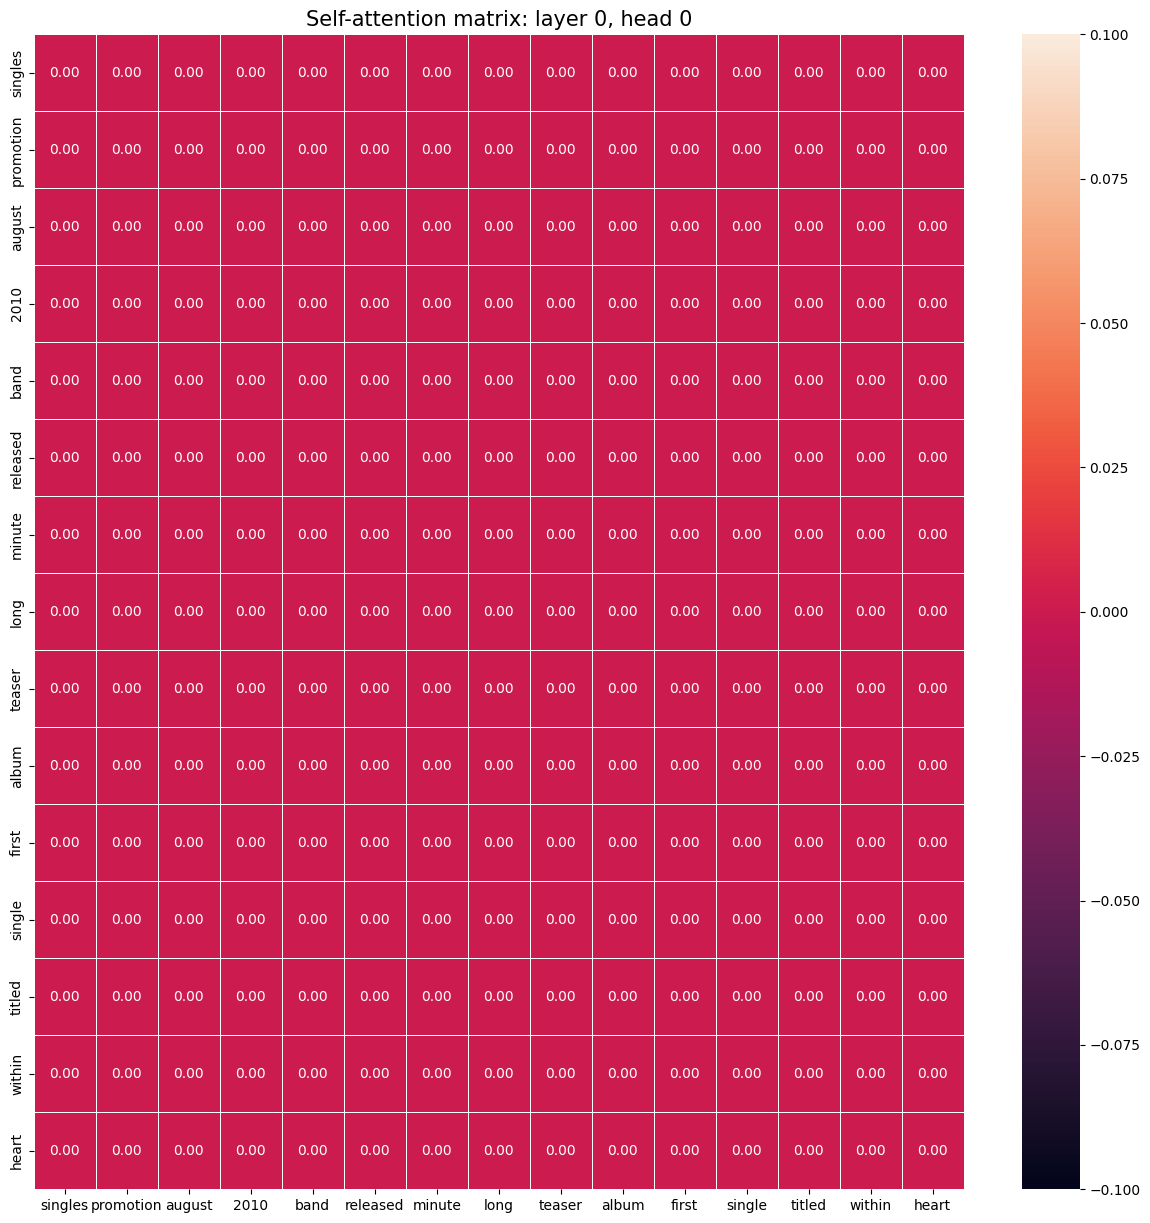

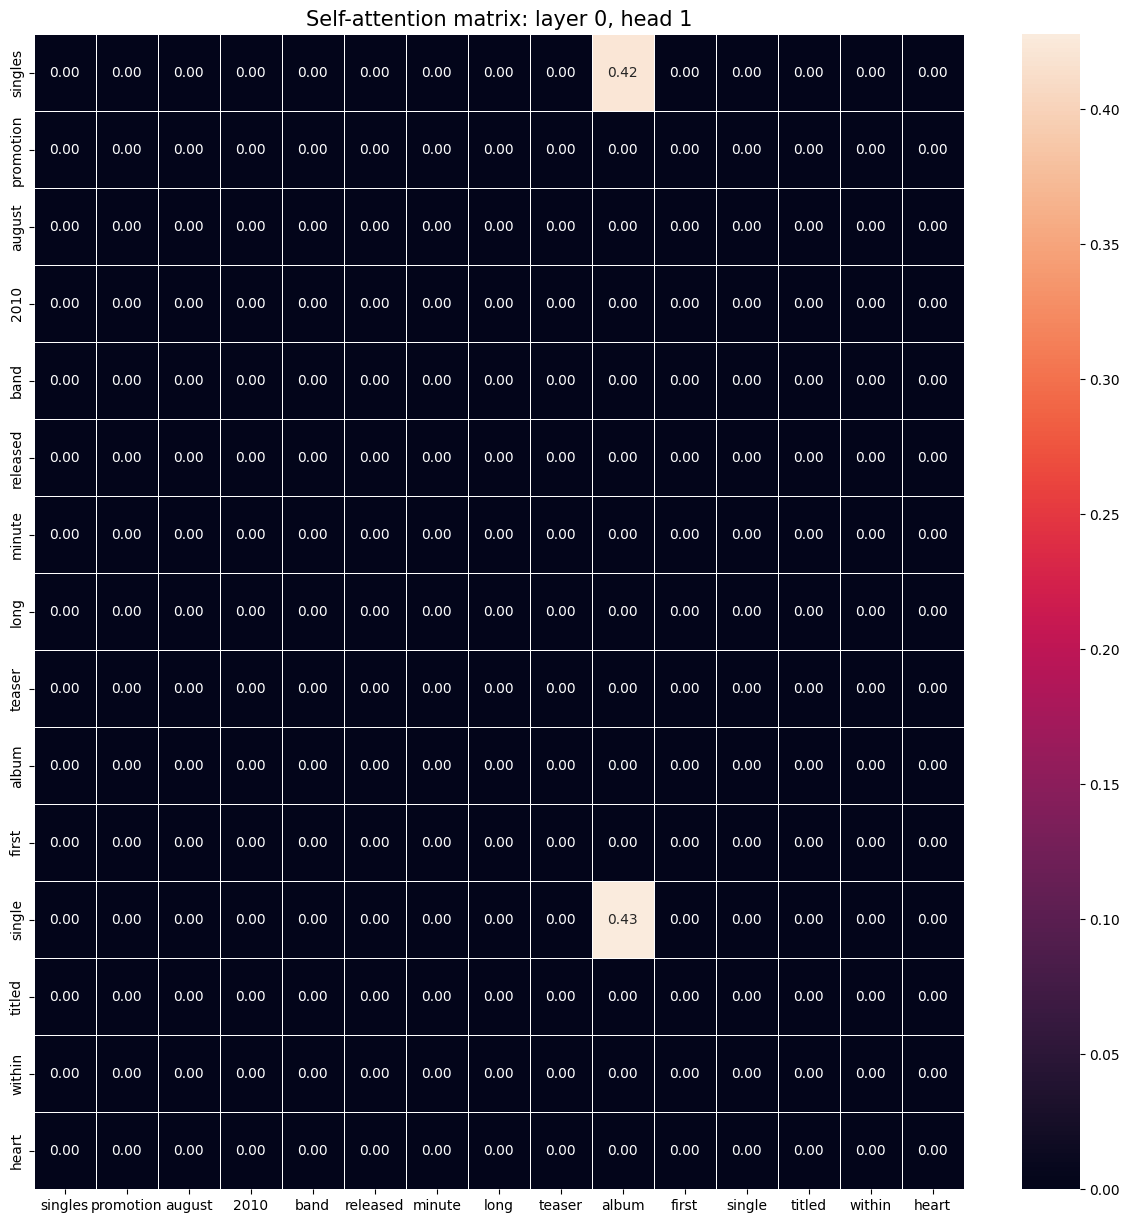

,seq,score,len
0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.42,2.0


['singles' 'album'] 0.42


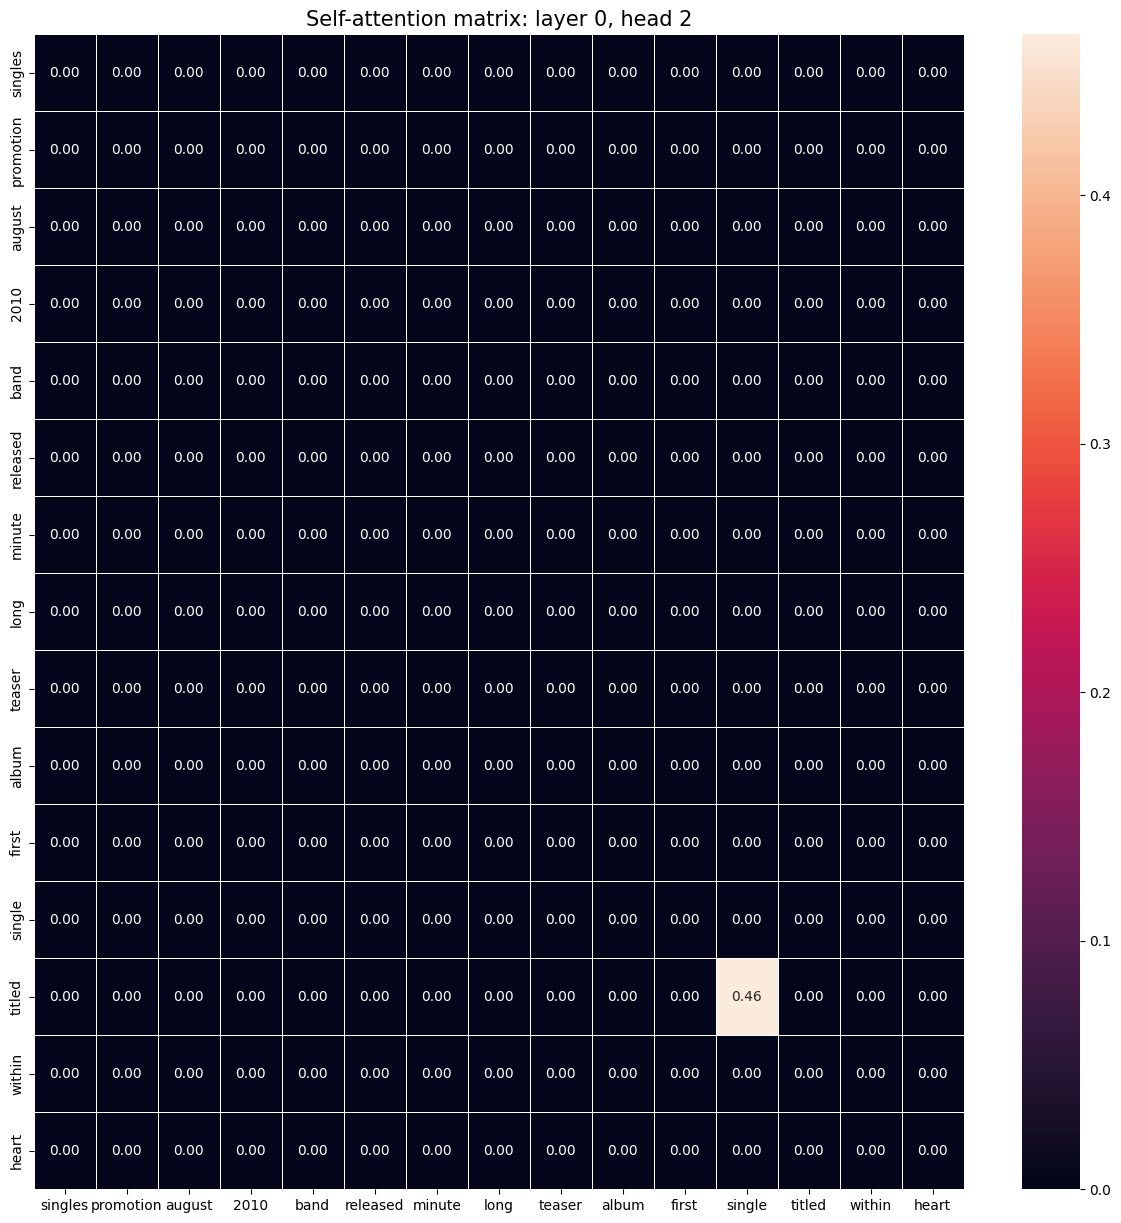

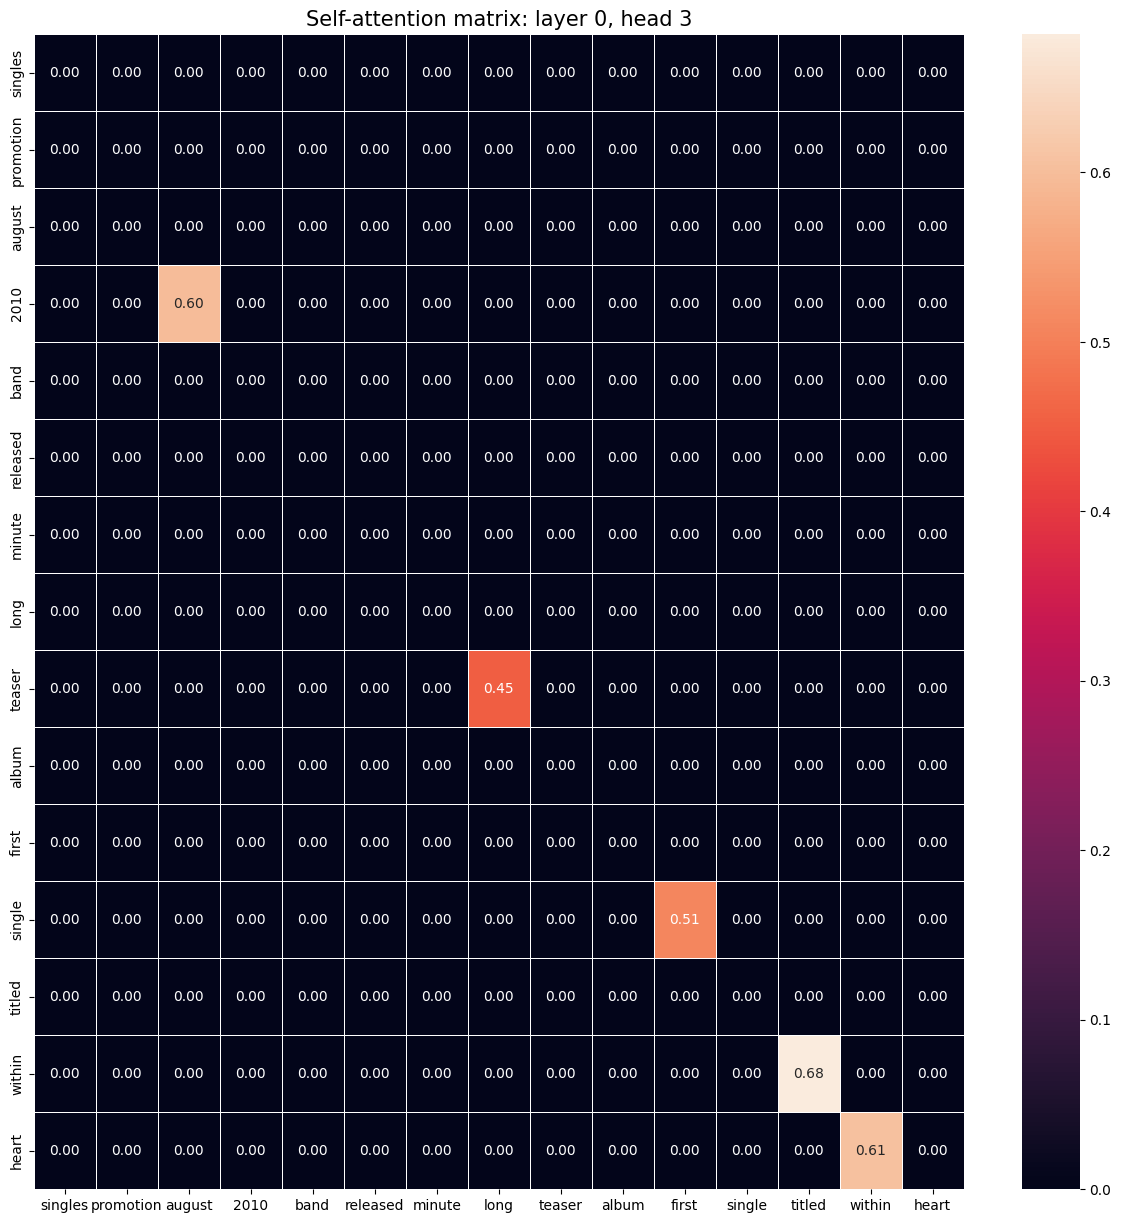

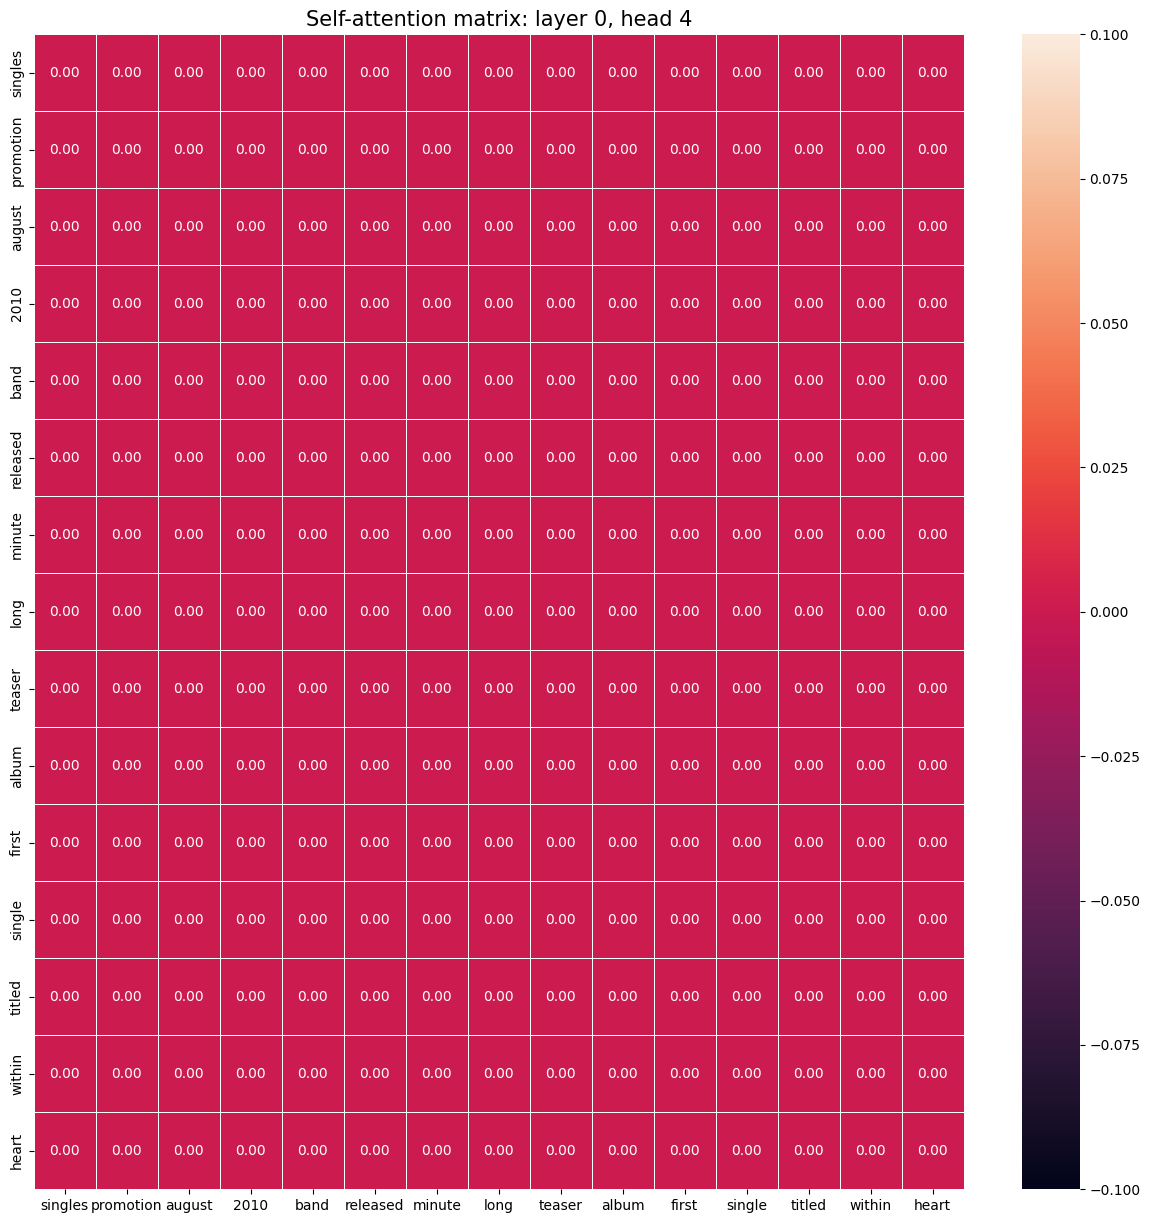

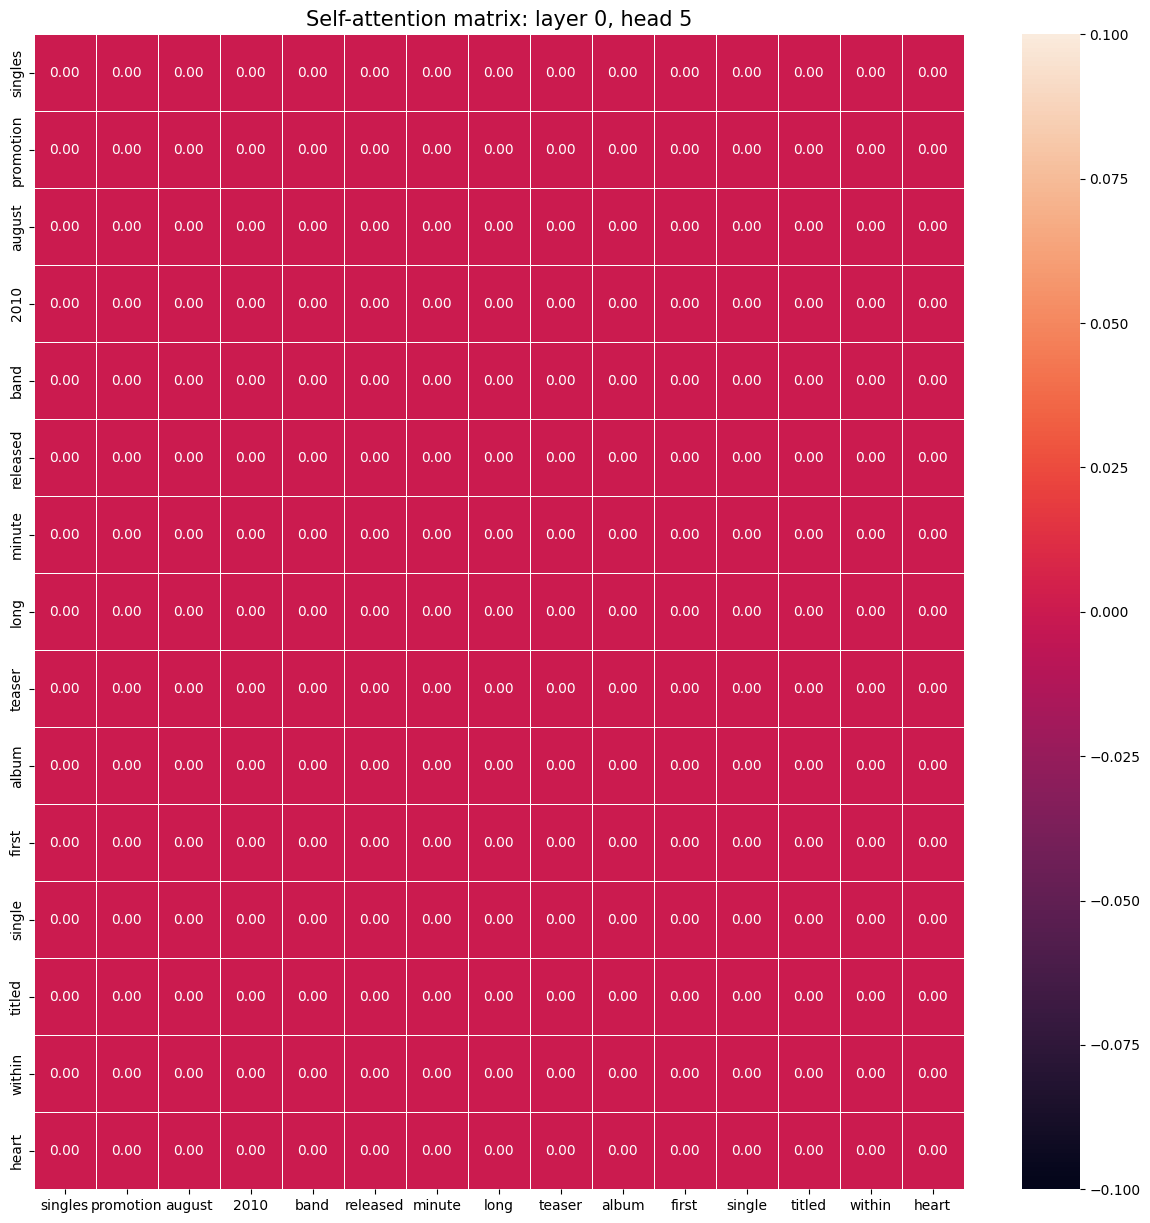

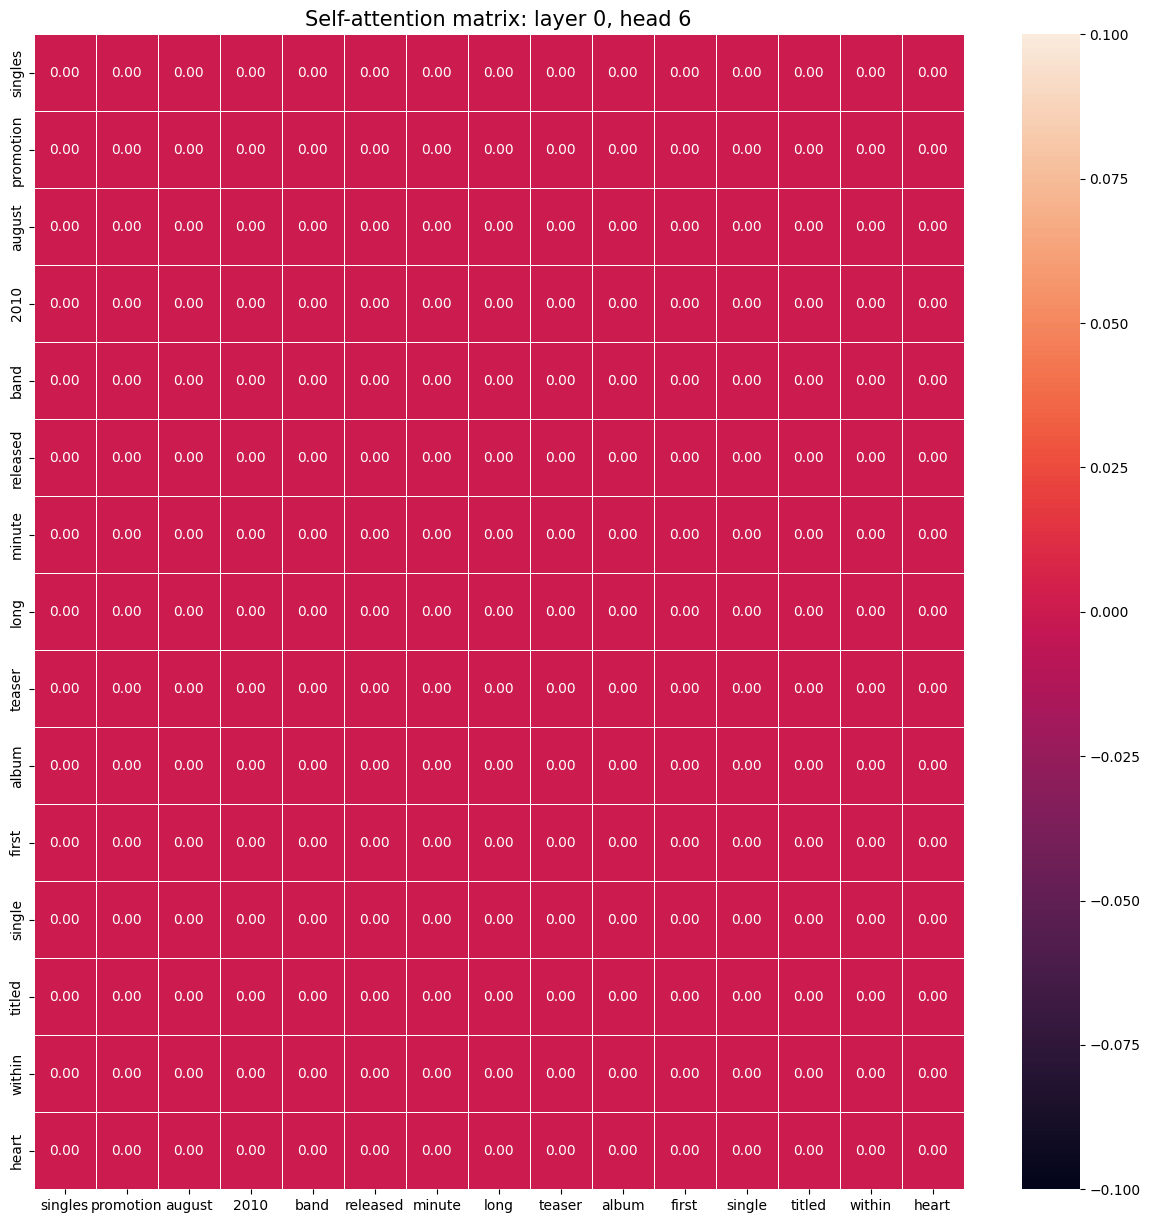

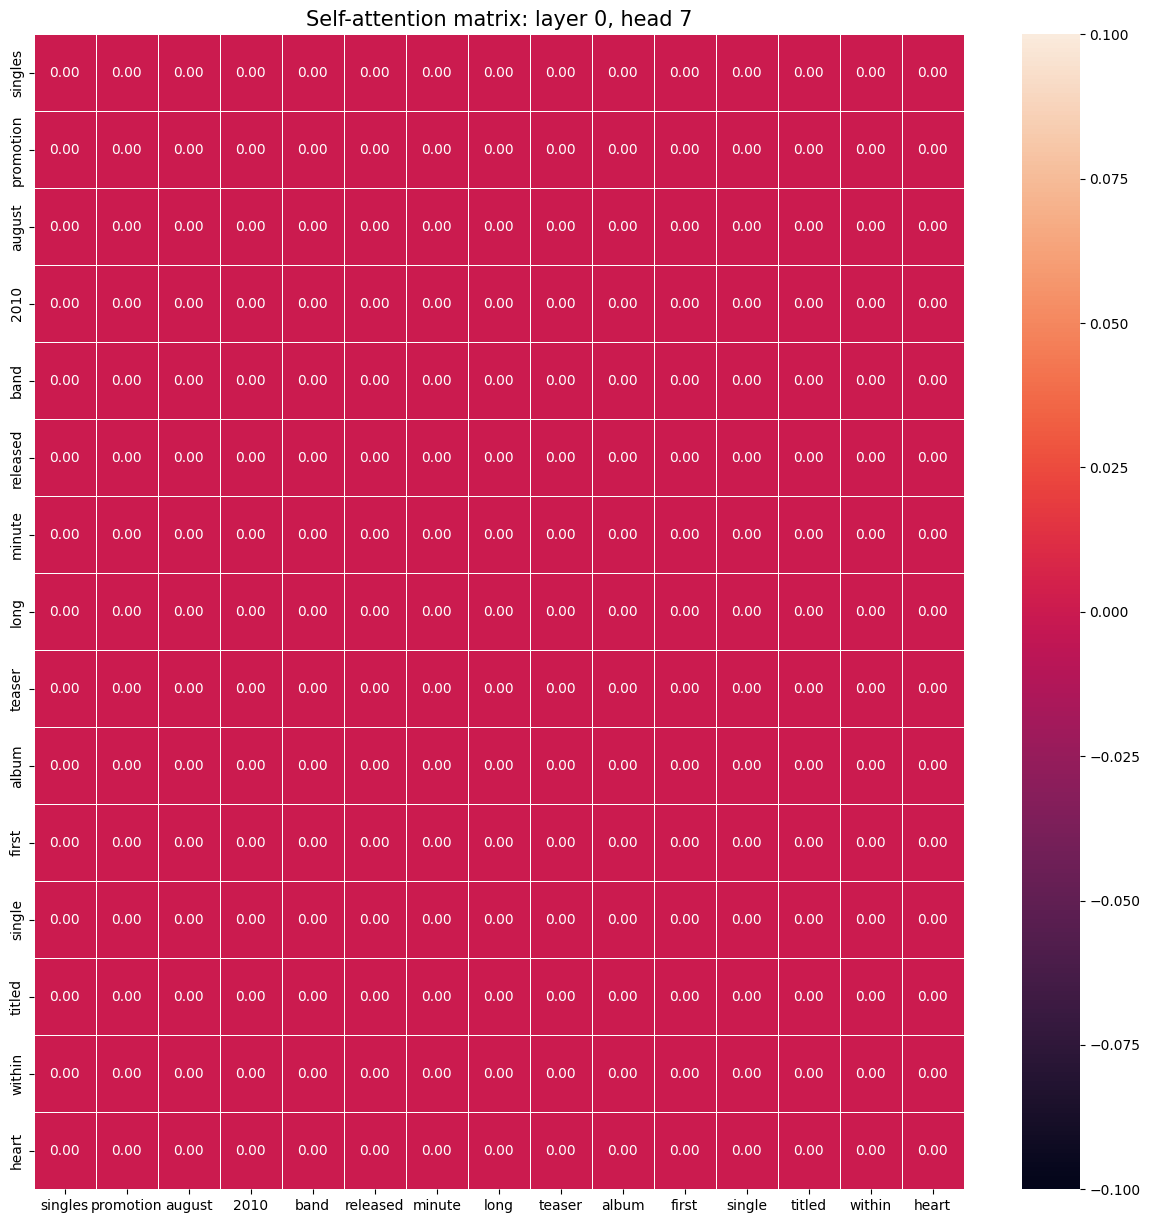

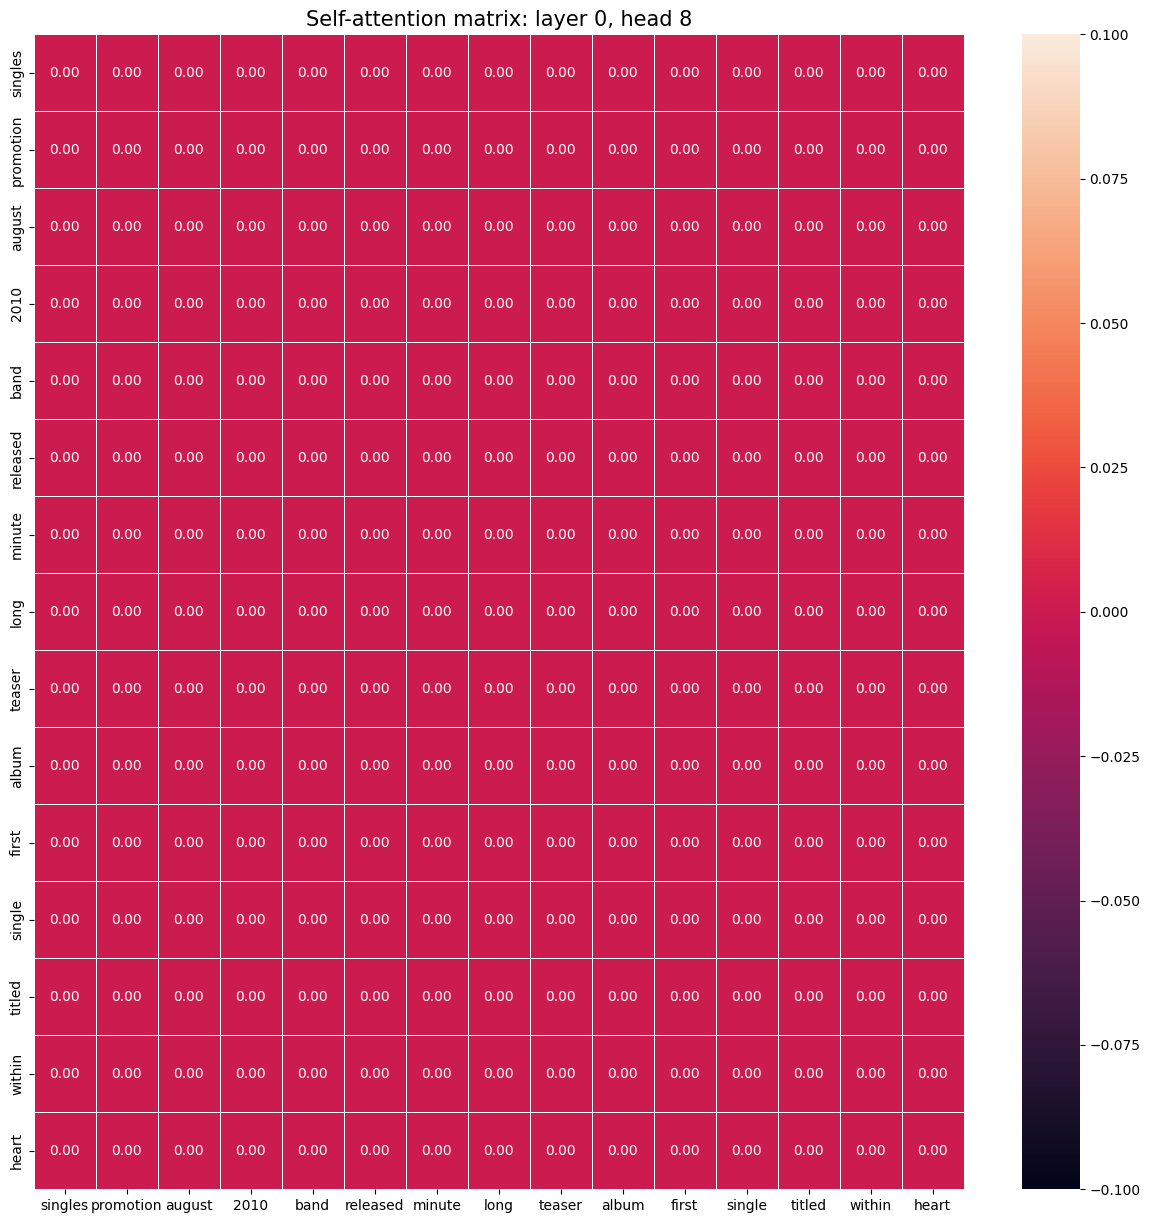

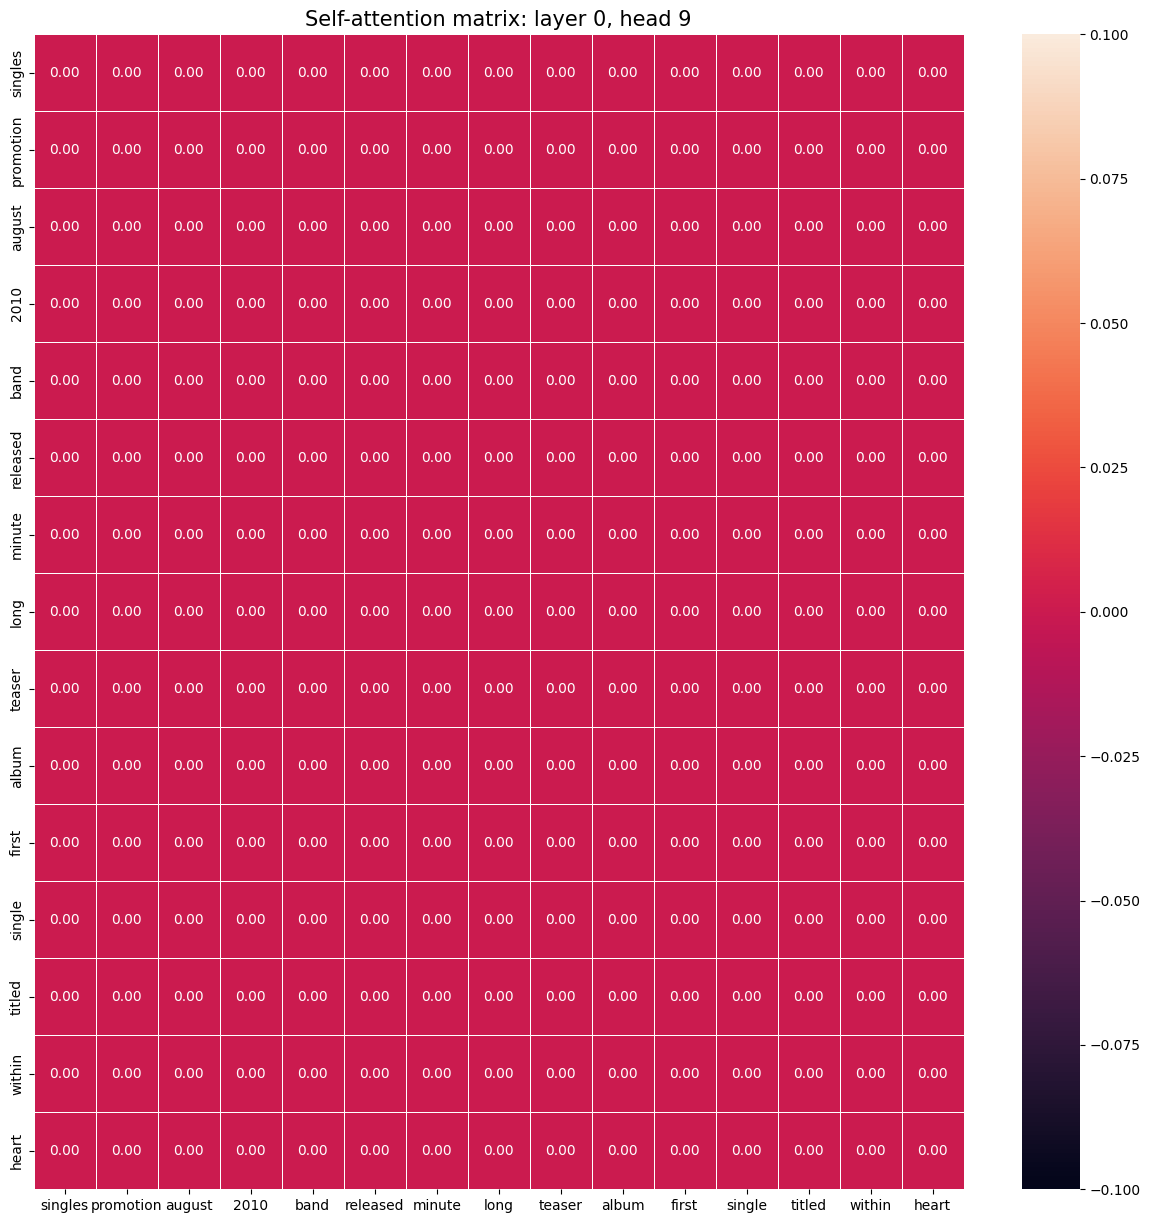

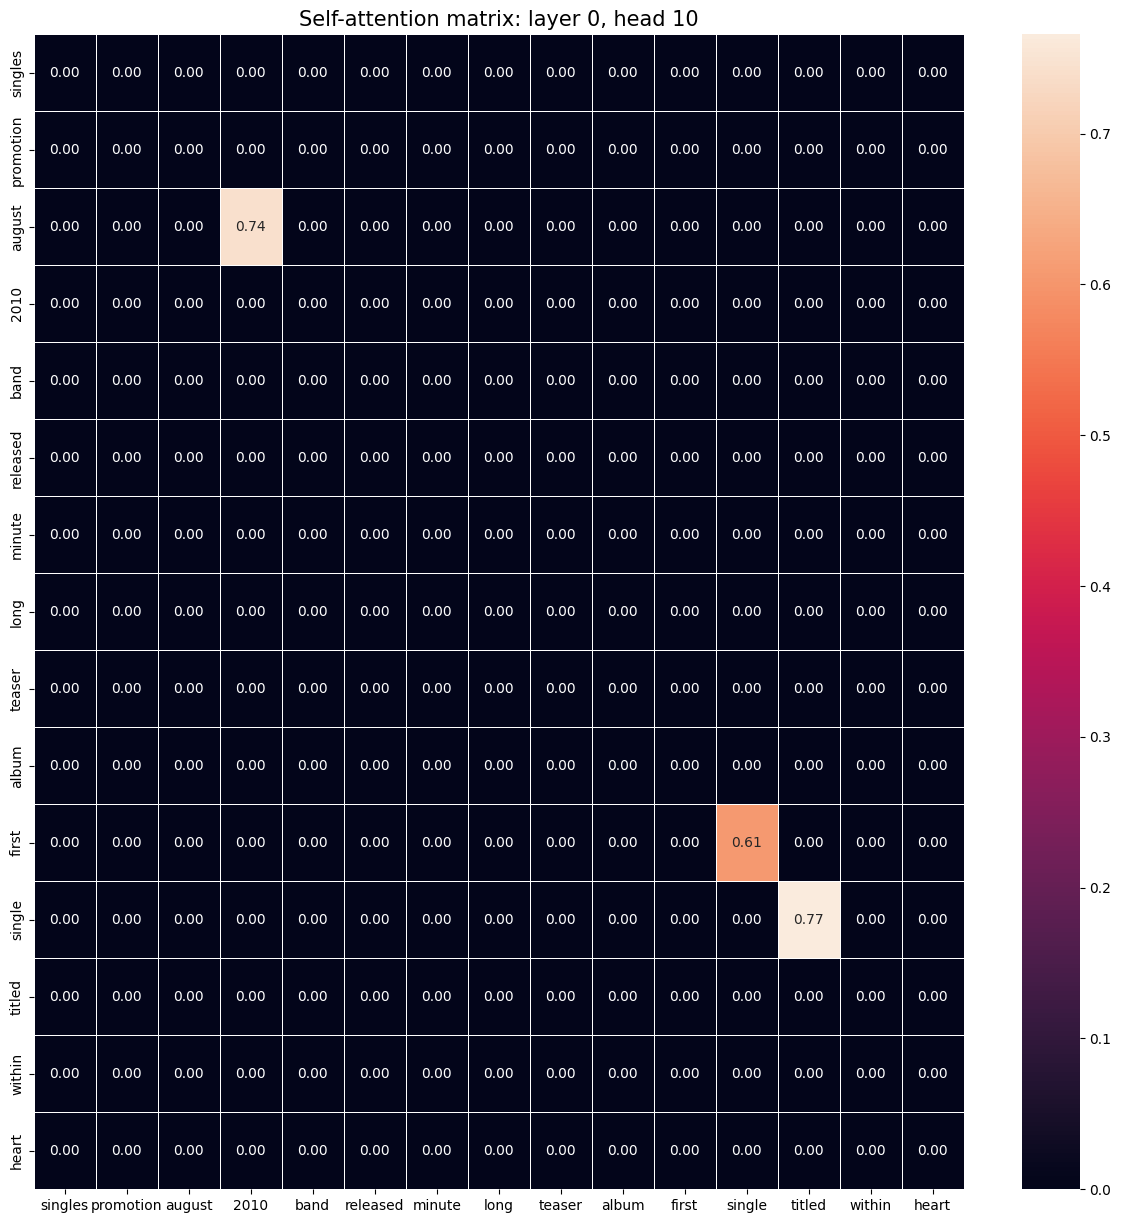

,seq,score,len
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.77,2.0
1,"[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.74,2.0
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.69,3.0
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.61,2.0


['single' 'titled'] 0.77
['august' '2010'] 0.74
['first' 'single' 'titled'] 0.69


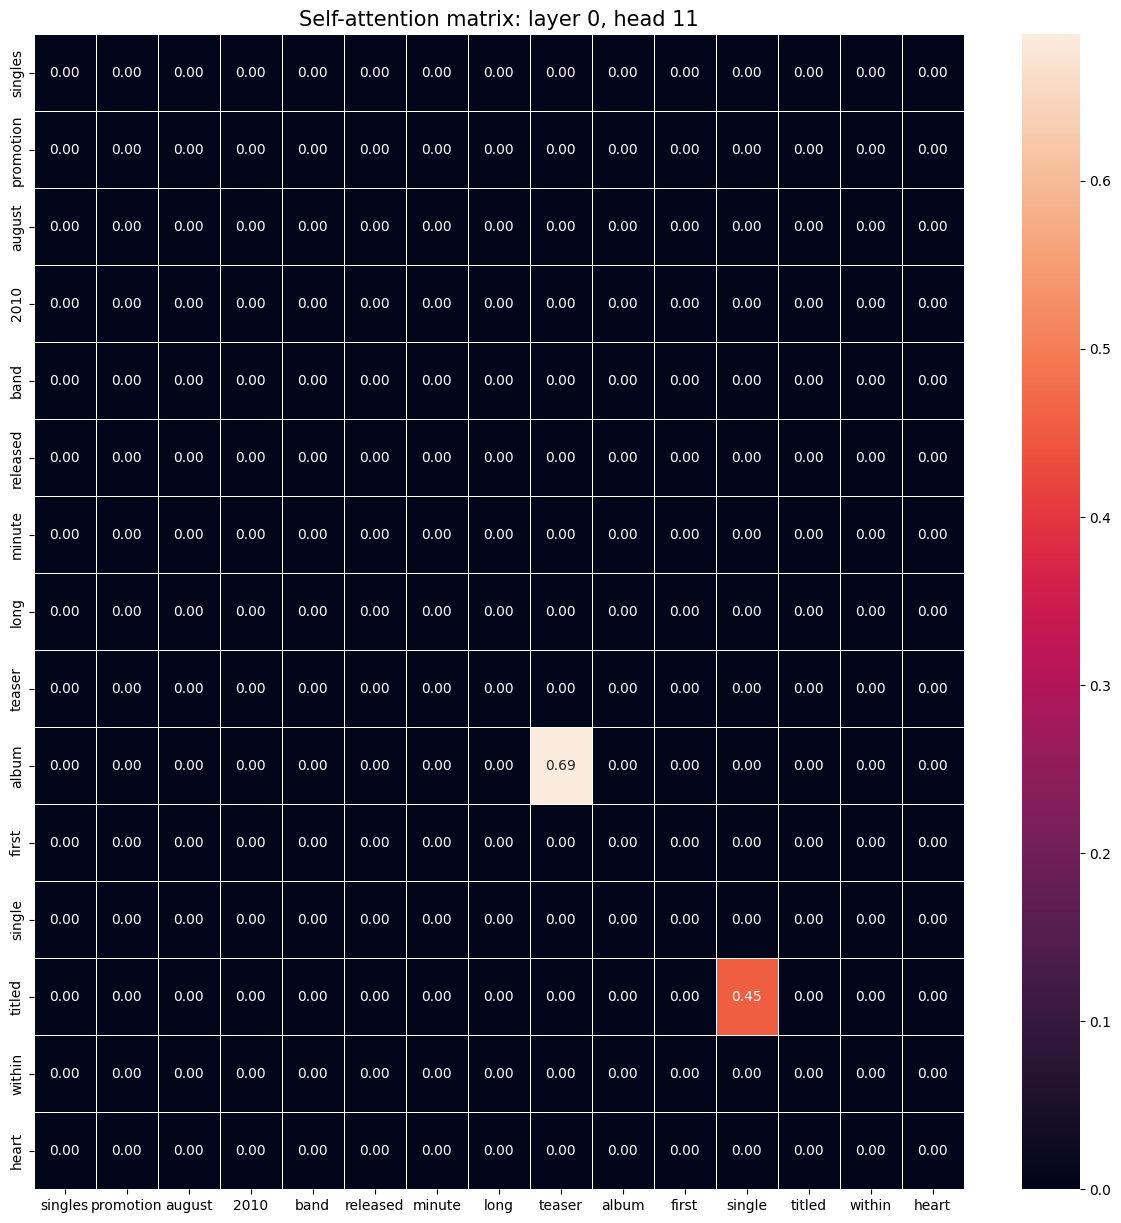

In [33]:
layer = 0

for head in range(12):
    head_scores_raw_tensor = attention_matrix[layer][0][head].detach().clone()
    
    head_scores_raw_tensor = preprocess_attention_scores(
        head_scores_raw_tensor, averages_idx, remove_idx
    )
        
    head_scores_raw = head_scores_raw_tensor.cpu().detach().numpy()
    
    head_scores = head_scores_raw[1:(len(head_scores_raw) - 1), 1:(len(head_scores_raw) - 1)].copy()

    as_threshold = 0.4
    head_scores[head_scores < as_threshold] = 0
    plot_heatmap(head_scores, labels)
    
    G = nx.from_numpy_array(head_scores, create_using = nx.DiGraph())
    G.edges.data()

    sequences = []
    means= []
    n_tokens = len(labels)
    construct_sequences(G, n_tokens)
        
    df = pd.DataFrame(data=[sequences, means]).T.rename(columns={0: 'seq',  1: 'score'})
    if len(df) > 0:
        df['len'] = df['seq'].map(sum)
        df['score'] = df['score'].astype('float64')
        df = df.sort_values(by=['score', 'len'], ascending=[False, False]).reset_index(drop=True)
        top3_df = df.head(3)
        display(df)
    
        for i in range(len(top3_df)):
            print(labels[top3_df['seq'][i].astype(bool)], top3_df['score'][i])
    
    #if sequences != []:
        #layer_sequences.append(sequences)
#     if sequences != []:
#         print(head)
#         for seq in sequences:
#             print(labels[seq.astype(bool)])

In [34]:
# text = "Firenze firenze"
# encoding = tokenizer.encode(text)
# labels = tokenizer.convert_ids_to_tokens(encoding)

In [35]:
# i = 0
# averages_idx = []
# while i < len(labels) - 1:
#     j = i + 1
#     average_idx = []
#     while labels[j].startswith('#'):
#         average_idx.append(j)
#         labels[i] += labels[j].replace('#', '')
#         j += 1
#     if average_idx != []:
#         average_idx.append(i)
#         averages_idx.append(average_idx)
#     i = j

# hashtag_idx = np.array([label.startswith("#") for label in labels])
# labels = np.array(labels)[~hashtag_idx]

In [36]:
# Torch implementation.

# t = torch.tensor(head_scores_raw)
# i = torch.tensor(averages_idx)

# t[i] = torch.mean(t[i], dim=1, keepdim=True)
# t = torch.unique_consecutive(t, dim=0)
# t = torch.transpose(t, 0, 1)
# t[i] = torch.mean(t[i], dim=1, keepdim=True)
# t = torch.unique_consecutive(t, dim=0)

# t = torch.transpose(t, 0, 1)